In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from astropy import constants as c
from astropy import units as u

from plasmapy.formulary import mass_density 
from plasmapy.formulary import collision_frequency
from plasmapy.particles import reduced_mass

# Properties of a stellar atmosphere

In this notebook we are going to examine some of the physical properties of a stellar atmosphere. We will use as our base the series of models known as FAL-93 ([Fontenla, Avert & Loeser, 1993](https://ui.adsabs.harvard.edu/abs/1993ApJ...406..319F/abstract)). These models are often used a proxy for the conditions on the Sun. However, as Rob Rutten likes to make clear: 

- *these are educational solar-analog “Avrett stars”. These computationally existing stars extend infinitely
plane-parallel (1D) without any inhomogeneities or any magnetism or any sort of waves or any type of reconnection – no granules, spicules, floccules, let be filaments, flares, CMEs, and whatever else that makes our kind Sun non-plane-parallel interesting. .... The solar atmosphere is not layered but
dynamically structured.* (Quote from [Rutten 2021](https://ui.adsabs.harvard.edu/abs/2021arXiv210302369R/abstract)).

With that made clear, let's look at a Sun.

In [2]:
# read in files
file_name = '/Users/richardmorton/analysis/FAL_models/fal_c.csv'
df = pd.read_csv(file_name, skiprows=[1])

In [3]:
# show columns
#df = df.drop(range(5))
df

,Unnamed: 0,Depth,Temp.,Electron,Proton,H(1),H(2),He(1),He(2),He II,He III
0,1,2220.0,103000.0,6.560000e+09,5.480000e+09,1.110000e+05,3.700000e-02,4.320000e+02,0.598,2.010000e+07,5.280000e+08
1,2,2220.0,98800.0,6.810000e+09,5.700000e+09,1.790000e+05,5.900000e-02,1.200000e+03,1.540,4.410000e+07,5.260000e+08
2,3,2220.0,94800.0,7.070000e+09,5.940000e+09,2.460000e+05,8.000000e-02,2.860000e+03,3.390,7.280000e+07,5.220000e+08
3,4,2220.0,90800.0,7.360000e+09,6.210000e+09,3.440000e+05,1.110000e-01,6.720000e+03,7.250,1.050000e+08,5.170000e+08
4,5,2210.0,83900.0,7.910000e+09,6.730000e+09,7.000000e+05,2.200000e-01,2.640000e+04,24.400,1.770000e+08,4.980000e+08
...,...,...,...,...,...,...,...,...,...,...,...
65,66,-20.0,6980.0,1.730000e+14,1.530000e+14,1.240000e+17,2.150000e+10,1.250000e+16,184.000,6.850000e+05,2.820000e-27
66,67,-40.0,7590.0,4.480000e+14,4.250000e+14,1.280000e+17,8.630000e+10,1.280000e+16,2660.000,8.370000e+06,2.180000e-23
67,68,-60.0,8220.0,1.050000e+15,1.020000e+15,1.300000e+17,2.900000e+11,1.310000e+16,27700.000,7.390000e+07,5.490000e-20
68,69,-80.0,8860.0,2.210000e+15,2.180000e+15,1.300000e+17,8.230000e+11,1.320000e+16,212000.000,4.890000e+08,4.960000e-17


## Number and mass density

From this data we will first calculate the total number densities of Hydrogen and Helium, and the total mass density, then show the density and temperature.

In [4]:
df['n_H'] = df['Proton']+df['H(1)']+df['H(2)']
df['n_He'] = df['He(1)']+df['He(2)']+df['He II']+df["He III"]

# rho in kg/m^3
df['rho'] = mass_density(df['n_H'].values * u.cm**-3, 'H') \
            + mass_density(df['n_He'].values * u.cm**-3, 'He')

## Coronal extension

To extend this model to the corona, we follow Soler et al. (2017). First, the temperature is defined by a parabolic profile, determined to match the value of T at the upper chromosphere/transition region, with a coronal temperature, in this case $T_{cor}=10^6$, i.e. $T=(a+z/b)^{1/2}$

The density is then determined by assuming a gravitational stratified atmosphere, i.e. $\nabla p=\rho \vec{g}$. This leads to the ODE:

$$
\frac{d\rho}{dz}+\frac{\rho}{T}\left(\frac{dT}{dz}+\frac{g\mu}{R}\right)=0
$$

$$
\frac{d T}{dz}= \frac{(a+z/b)^{-1/2}}{2b}
$$

This has an analytic solution but we solve with Euler's method.

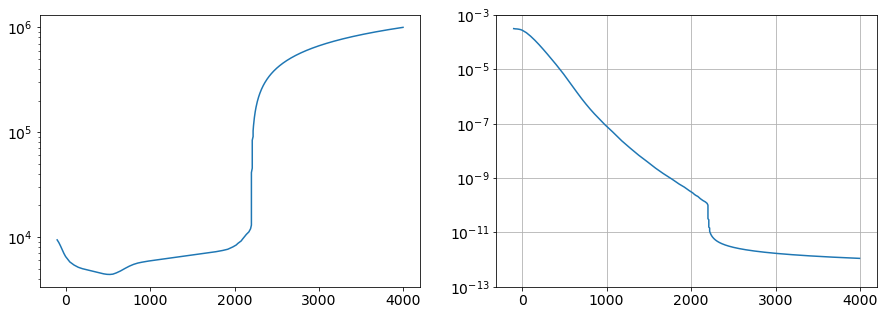

In [43]:
# Add corona

# Initial conditions
T_cor = 1e6 # K
z_cor = 4000 # km

z_step = 5 # step size

# solar constants
g_sun = 274*u.m*u.s**-2 # solar gravity
g_sun = g_sun.to(u.km*u.s**-2)
R = 8.3e3*u.m**2*u.s**-2*u.K**-1 # gas constant
R = R.to(u.km**2*u.s**-2*u.K**-1)
mu = 0.6 # mean atomic weight

# parabolic profile for T
b = (z_cor-df['Depth'][0])/(T_cor**2-df['Temp.'][0]**2)
a = df['Temp.'][0]**2-1/b*df['Depth'][0]

depth_cor = np.arange(df['Depth'][0], z_cor, z_step) # km
coronal_T_prof = np.sqrt(a+1/b*depth_cor)
test_profile = np.concatenate((coronal_T_prof[::-1],df["Temp."].values))
test_depth = np.concatenate((depth_cor[::-1], df["Depth"].values))

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(test_depth, test_profile)
plt.yscale('log')

# density from gravitational stratifiction
rho_cor = []
for i, z_c in enumerate(depth_cor.tolist()):
    if i == 0:
        rho_n = df['rho'][0]
    else:
        rho_n = rho_cor[-1]
    f = (a+1/b*z_c)**-0.5/2/b+(g_sun*mu/R).value
    rho_cor.append(rho_n-z_step*rho_n*f/coronal_T_prof[i])

test_rho_profile = np.concatenate((np.array(rho_cor)[::-1], df["rho"].values))
plt.subplot(122)
plt.plot(test_depth, test_rho_profile)
plt.yscale('log')
plt.ylim(1e-13,1e-3)
plt.grid()

<Figure size 1080x360 with 0 Axes>

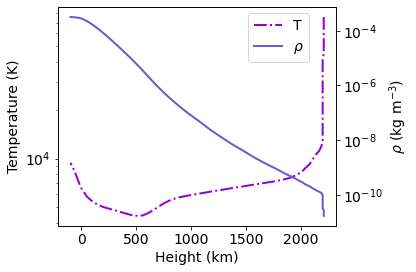

In [301]:
plt.figure(figsize=(15,5))
fig, ax1 =plt.subplots()

ax1.plot(df['Depth'], df['Temp.'], label='T', color='darkviolet', lw=2, linestyle='-.')
ax1.set_yscale('log')
ax1.set_xlabel('Height (km)')
ax1.set_ylabel('Temperature (K)')
#ax1.grid(axis='y')

ax2 = ax1.twinx()

ax2.plot(df['Depth'], df['rho'], label=r'$\rho$', color='slateblue', lw=2)
ax2.set_yscale('log')
ax2.set_ylabel(r'$\rho$ (kg m$^{-3}$)')

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.75,0.95));

## Magnetic field geometry

Here we detail the magnetic field geometry of a small-scale magnetic flux tube, likely to be close to those observed in intergranular lanes (magnetic bright points). The specific form of the magnetic field is a semi-empirical formula suggested in Leake et al. (2005).

$$
B_z(z)=B_{ph}\left(\frac{\rho(z)}{\rho_{ph}}\right)^\epsilon,
$$

where subscript $ph$ corresponds to photospheric values, and $\epsilon$ is a free parameter that controls the expansion of the magnetic field.

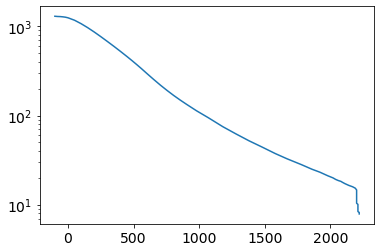

In [52]:
def create_mag_field(B_ph, rho, epsilon):
    return B_ph * (rho / rho[-1])**epsilon

rho = df['rho'].values
b_z = create_mag_field(1300, rho, 0.3)
plt.plot(df['Depth'], b_z)
plt.yscale('log')

## Fractions of species
Now we will calculate the fractions of each species in the atmosphere,as
$$
\xi_\beta = \frac{\rho_{\beta}}{\rho}
$$
where $\rho_\beta =m_\beta n_\beta$ is the mass density of species $\beta =$ e, p, H, He I, or He II.

In [303]:
rho = df['rho'] * (u.kg * u.m**-3)

df['xi_H_n'] = mass_density((df['H(1)']+df['H(2)']).values * u.cm**-3, 'H') /rho
df['xi_H_i'] = mass_density(df['Proton'].values * u.cm**-3, 'p') /df['rho']
df['xi_He_n'] = mass_density((df['He(1)']+df['He(2)']).values * u.cm**-3, 'He') /rho
df['xi_He_i'] = mass_density((df['He II']+df["He III"]).values * u.cm**-3, 'He') /rho
df['xi_He_II'] = mass_density((df['He II']).values * u.cm**-3, 'He') /rho


# all ions and neutrals
df['xi_i'] = df['xi_H_i']+df['xi_He_i']
df['xi_n'] = df['xi_H_n']+df['xi_He_n']

First we'll plot the fractions of individual species.

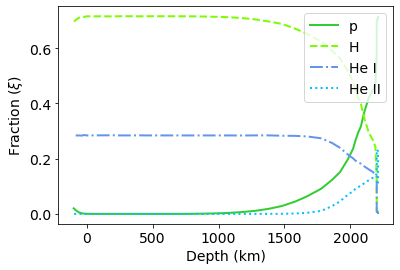

In [323]:
# plot code
plt.plot(df['Depth'], df['xi_H_i'], label='p', color='limegreen', lw=2)
plt.plot(df['Depth'], df['xi_H_n'], label='H', color='lawngreen', linestyle='--', lw=2)
plt.plot(df['Depth'], df['xi_He_n'], label='He I', color='cornflowerblue', linestyle='-.', lw=2)
plt.plot(df['Depth'], df['xi_He_II'], label='He II', color='deepskyblue', linestyle=':', lw=2)
plt.xlabel('Depth (km)')
plt.ylabel(r'Fraction ($\xi$)')
plt.legend(loc='upper right');

And now the the fractions of ions and neutrals.

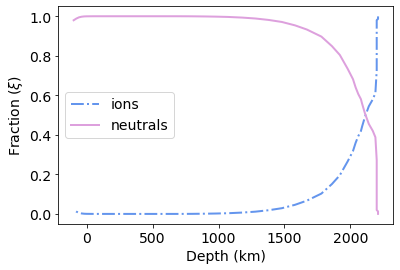

In [325]:
# plot code
plt.plot(df['Depth'], df['xi_i'], label='ions', color='cornflowerblue', linestyle='-.', lw=2)
plt.plot(df['Depth'], df['xi_n'], label='neutrals', color='plum', lw=2)
plt.xlabel('Depth (km)')
plt.ylabel(r'Fraction ($\xi$)')
plt.legend();

## Collision Frequencies

Of interest in many applications are the coefficients of friction, and/or the collision frequencies of the particles and different species. These equations can be found in many places, but I found the following references helpful ([Zaqarashvili et al. 2013](https://ui.adsabs.harvard.edu/abs/2011A%26A...529A..82Z/abstract); [Soler et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...573A..79S/abstract); [Soler et al. 2017](https://ui.adsabs.harvard.edu/abs/2017ApJ...840...20S/abstract); [Soler et al 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...871....3S/abstract))

We will be interested in the collisions between charged particles, and also neutrals and charged particles. Here we define a few equations of interest.

Ion-neutral coefficient of friction (Braginskii 1965 ):
$$
\alpha_{\beta\beta'} = n_\beta n_{\beta'}m_{\beta\beta'}\sigma_{\beta\beta'}\frac{4}{3}\sqrt{\frac{8 k_B T}{\pi m_{\beta\beta'}}}
$$

with collision frequency
$$
\nu_{\beta\beta'}= \frac{\alpha_{\beta\beta'}}{m_\beta n_\beta + m_{\beta'}n_{\beta'}}
$$

Where 
$$
m_{\beta\beta'} = \frac{m_\beta m_{\beta'}}{m_\beta + m_{\beta'} }
$$
is the reduced mass and $\sigma_{\beta\beta'}$ are the collisional cross sections. 



The collisional cross-sections can be calculated from ... We use the following values from (Lewkow et al. 2012; [Vranjes & Krstic 2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...554A..22V/abstract)).


**Ion-neutral cross sections**:
- $\sigma_{iH} \approx 10^{-18}$~m^2, 
- $\sigma_{iHeI} \approx 3\times 10^{-19}$ m^2,
- $\sigma_{HHeI} \approx 1.5\times 10^{-19}$ m^2 

**Electron-neutral**:
- $\sigma_{eH}= 3\times10^{-19}$~m^2
- $\sigma_{eHe}= 6\times10^{-20}$~m^2


The friction coefficient for collisions between two charged species is (e.g., Spitzer 1962; Braginskii 1965)
$$
\alpha_{qq'}=\frac{n_q n_{q'}e^4 \Lambda_{qq'}}{6\pi\sqrt{2\pi}\epsilon_0^2m_{qq'}}\left(\frac{m_{qq'}}{k_BT} \right)^{3/2},
$$
where $q$ = e, p, or He II and $q'=$ e, p, or He II,

The Coulomb logarithm Λ is given by (e.g., Spitzer 1962; Vranjes & Krstic 2013)
$$
\Lambda_{qq'}=\ln\left( \frac{24\pi(\epsilon_0k_BT)^{3/2}}{e^3\sqrt{n_q+n_{q'}}} \right)
$$

Units of $\alpha_{qq'}$ are kg/s/m$^3$.

And the total friction coefficient of species $\beta$ with
the other species is
$$
\alpha_{\beta}=\sum_{\beta'\neq\beta}\alpha_{\beta\beta'}
$$



In [117]:
# functions for calculation of coefficients of friction

def calc_in_coeff_fric(n_i, n_n, m_in, sigma_in,T):
    """
    Calculate coefficient of friction for charged and neutrals (Eq. 2).
    
    n_i - ion number density
    n_n - neutral number density
    m_in - reduced mass
    sigma_in - cross section
    T - temperature 
    
    output units should be kg/s/m^3
    """
    return n_i*n_n*m_in*sigma_in*4/3*np.sqrt( (8*c.k_B*T)/(np.pi*m_in) )

def coloumb_logarithm(n_1, n_2, T):
    """
    Calculate couloumb logarithm (Eq. 6).
    
    n_1 - charged particle number density
    n_2 - charged particle number density
    T - temperature 
    """
    numer = 24*np.pi*(c.eps0*c.k_B*T)**(3/2)
    denom = c.e.si**3*np.sqrt(n_1+n_2)
    return np.log(numer/denom)

def calc_qq_coeff_fric(n_1, n_2, m_12, T):
    """
    Calculate coefficient of friction for charged particles (Eq. 5).
    
    n_1 - charged particle number density
    n_2 - charged particle number density
    m_12 - reduced mass
    T - temperature 
    
    output units should be kg/s/m^3
    """
    coloumb_log = coloumb_logarithm(n_1, n_2, T)
    numer = n_1*n_2*c.e.si**4*coloumb_log
    denom = 6*np.pi*np.sqrt(2*np.pi)*c.eps0**2*m_12
    
    
    return numer/denom*( m_12/c.k_B/T )**(3/2)


Let us now calculate this for the electron collisions. We do this in two ways, one including only charged particles and the other including neutrals.

In [314]:
# electron - charged
q_prime = ['p', 'He II', 'He III']
q_prime_lab = ['Proton', 'He II', 'He III']
label = ['alpha_ep', 'alpha_eHeII', 'alpha_eHeIII']

n_1 = df['Electron'].values * u.cm**-3
Temp = df['Temp.'].values * u.K

for qp, qp_lab, lab in zip(q_prime, q_prime_lab, label):
    red_mass = reduced_mass('e',qp)
    n_2 = df[qp_lab].values * u.cm**-3 # number density
    a = calc_qq_coeff_fric(n_1, n_2, red_mass, Temp )
    df[lab] = a.decompose().value

# electron - neutrals
red_mass = reduced_mass('e','H')
sigma_eH = 3 * 10**-19 * u.m**2
n_2 = (df['H(1)']+df['H(2)']).values*u.cm**-3 # neutral hydrogen number density
a = calc_in_coeff_fric(n_1, n_2, red_mass, sigma_eH, Temp )
df['alpha_e_H'] = a.decompose().value
       
red_mass = reduced_mass('e','He')
sigma_eHe = 6 * 10**-20 * u.m**2
n_2 = (df['He(1)']+df['He(2)']).values * u.cm**-3 # neutral helium number density
a = calc_in_coeff_fric(n_1, n_2, red_mass, sigma_eHe, Temp )
df['alpha_e_He'] = a.decompose().value 


# charged particles only
df['alpha_e_q'] = df['alpha_ep']+df['alpha_eHeII']+df['alpha_eHeIII']

# neutrals + charged particles only
df['alpha_e'] = df['alpha_e_q']+df['alpha_e_H']+df['alpha_e_He']

2050000.629 1 / cm3
125094.2 1 / cm3


It can be seen in the following plot that failure to include the collisions with neutrals in the lower solar solar atmosphere under-estimates the coefficient of friction for electron collisions. Collisions with neutral hydrogen and helium independently can be greater than collisions with the protons, between 100-500 km.

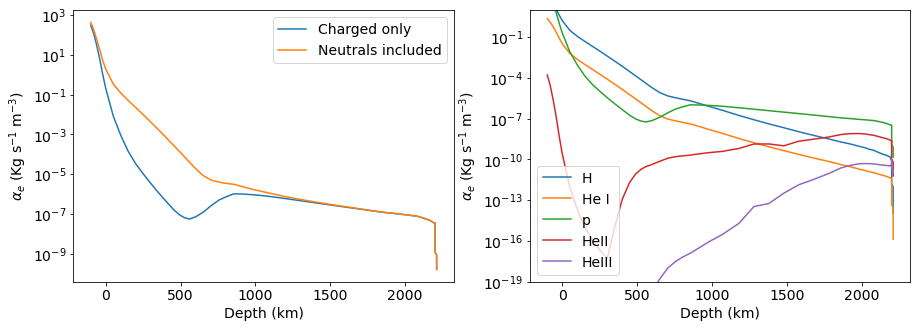

In [334]:
# plot code
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(df['Depth'], df['alpha_e_q'], label='Charged only')
plt.plot(df['Depth'], df['alpha_e'], label='Neutrals included')
plt.yscale('log')
plt.ylabel(r'$\alpha_e$ (Kg s$^{-1}$ m$^{-3}$)')
plt.xlabel('Depth (km)')
plt.legend()

plt.subplot(122)
label =  ['alpha_e_H','alpha_e_He','alpha_ep', 'alpha_eHeII', 'alpha_eHeIII']
leg_lab =  ['H','He I','p', 'HeII', 'HeIII']

for l, ll in zip(label, leg_lab):
    plt.plot(df['Depth'], df[l], label=ll)

plt.yscale('log')
plt.ylabel(r'$\alpha_e$ (Kg s$^{-1}$ m$^{-3}$)')
plt.ylim(1e-19,10)
plt.xlabel('Depth (km)')
plt.legend()

In [71]:
# proton-neutral hydrogen
red_mass = reduced_mass('p','H')
sigma_iH = 10**-18*u.m**2


n_i = df['Proton'].values*u.cm**-3
n_n = (df['H(1)']+df['H(2)']).values*u.cm**-3
a = calc_in_coeff_fric(n_i, n_n, red_mass, sigma_iH, df['Temp.'].values*u.K )
df['alpha_pH'] = a.decompose().value

Eqs. (142-145)

Ohmic diffusion
$$
\eta = \frac{α_e}{(en_e)^2\mu}
$$

Hall diffusion
$$
\eta_H = \frac{|B|}{en_e\mu}
$$

Ambipolar (Pederson/Cowling)
$$
\eta_A = \frac{\xi^2_n}{\alpha_n\mu} |B|^2
$$

Biermann Battery
$$
\eta_p = \frac{|B|}{en_e\mu}
$$

In [215]:
# eta_q - charged particles only
alpha_e_q = df['alpha_e_q'].values * u.kg * u.m**-3 / u.s
n_e = df['Electron'].values*u.cm**-3

df['eta_q'] = (alpha_e_q / (c.e.si * n_e)**2 / c.mu0).decompose()


# eta - charged _ neutrals particles
alpha_e = df['alpha_e'].values * u.kg * u.m**-3 / u.s

df['eta'] = (alpha_e / (c.e.si * n_e)**2 / c.mu0).decompose()

(1, 100000.0)

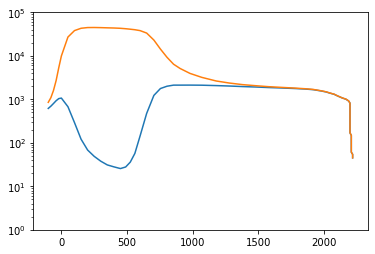

In [218]:
plt.plot(df['Depth'], df['eta_q'])
plt.plot(df['Depth'], df['eta'])
plt.yscale('log')
plt.ylim(1,1e5)